In [1]:
# 授权绑定Google Drive 
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools 
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null 
!apt-get update -qq 2>&1 > /dev/null 
!apt-get -y install -qq google-drive-ocamlfuse fuse 
from google.colab import auth 
auth.authenticate_user() 
from oauth2client.client import GoogleCredentials 
creds = GoogleCredentials.get_application_default() 
import getpass 
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL 
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 113598 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [1]:
# 指定Google Drive云端硬盘的根目录，名为drive
!mkdir -p drive
!google-drive-ocamlfuse drive

# 指定当前的工作目录
import os

# 此处为google drive中的文件路径,drive为之前指定的工作根目录，要加上
os.chdir("drive/Acoustic_Localization/keras/data/data_19_1") 


# 查看文件目录，是否包含所需的文件
!ls

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option
drive  qd_LOS_32_berlin_20k.mat  qd_NLOS_32_berlin_20k.mat  v_LOS_32_20k.mat


In [1]:
import scipy.io as sio
import numpy as np
import tensorflow as tf
import keras
from keras import backend as KK
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Flatten
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
#import seaborn as sns; sns.set()
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from keras import regularizers

Using TensorFlow backend.


In [3]:
#loading data
# DDataFile = './v_LOS_32_20k.mat'
DDataFile = './data/data_Emre/v_LOS_32_20k.mat'
DData = sio.loadmat(DDataFile)
#get the coeff data
h_coeff = DData['h_coeff']
location = DData['positions']
#split the D_data and location_data and only need the first 2k
N = 20000
M = 32
h_coeff = h_coeff[:,:N]
loc = np.transpose(location[:,:N])
print("h_coeff shape", h_coeff.shape)
print("loc shape", loc.shape)

D = np.asmatrix(np.fft.fft(np.eye(M)/np.sqrt(M)))
DH = D.H
F = np.zeros([N, M * M], dtype = "complex_")

for i in range(N):
    h = np.asmatrix(h_coeff[:, i:i+1])
    hH = h.getH()
    K = h * hH
    B = D * K * DH
    F[i] =B.flatten().A
F = np.transpose(np.asarray(F))
print(F.shape)
print(type(F))


h_coeff shape (32, 20000)
loc shape (20000, 2)
(1024, 20000)
<class 'numpy.ndarray'>


In [4]:

real_D = np.real(F)
img_D = np.imag(F)
print(real_D.shape, type(real_D[0]))

# concatenate the real and imaginary part
# com =  np.concatenate((real_D, img_D),axis=1)

com =  np.transpose(np.array([real_D,img_D]))

print(com.shape)
#print(com[0],F[0])

print(F.shape,loc.shape)
total, l = F.shape
total, d = loc.shape

train_length = int(np.floor(total * 0.8))

impulses_train = com[:train_length, :]
location_train = loc[:train_length,:]
print(total,train_length, impulses_train.shape, location_train.shape)

impulses_test = com[train_length:, :]
location_test = loc[train_length:,:]


print(impulses_train.shape, impulses_test.shape)    


# input image dimensions
img_rows, img_cols = 1024, 2

if KK.image_data_format() == 'channels_first':
    impulses_train = impulses_train.reshape(impulses_train.shape[0], 1, img_rows, img_cols)
    impulses_test = impulses_test.reshape(impulses_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    impulses_train = impulses_train.reshape(impulses_train.shape[0], img_rows, img_cols, 1)
    impulses_test = impulses_test.reshape(impulses_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)


print('impulses_train shape:', impulses_train.shape)
print('impulses_test shape:', impulses_test.shape)
print(impulses_train.shape[0], 'impulses_train samples')
print(impulses_test.shape[0], 'impulses_test samples')

(1024, 20000) <class 'numpy.ndarray'>
(20000, 1024, 2)
(1024, 20000) (20000, 2)
20000 16000 (16000, 1024, 2) (16000, 2)
(16000, 1024, 2) (4000, 1024, 2)
impulses_train shape: (16000, 1024, 2, 1)
impulses_test shape: (4000, 1024, 2, 1)
16000 impulses_train samples
4000 impulses_test samples


In [5]:
print(impulses_train[0].shape)


a = impulses_train[:1, :]
print(a.shape)
print(input_shape)
#print(a)

(1024, 2, 1)
(1, 1024, 2, 1)
(1024, 2, 1)


In [0]:
#Build the model
model = keras.Sequential()

model.add(keras.layers.normalization.BatchNormalization())

model.add(keras.layers.Conv2D(516, kernel_size=(2, 2),
                 activation='relu',
                 padding='same',
                 input_shape=input_shape))

# model.add(keras.layers.Conv2D(128, kernel_size=(2, 2),
#                  activation='relu',
#                  padding='valid',
#                  ))

# model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None))
# model.add(keras.layers.MaxPooling1D(pool_size=2, strides=None, padding='valid'))

model.add(Flatten())
# keras.layers.Flatten()

model.add(Dense(1024, activation = 'relu'))   #the hidden layer number 

model.add(Dense(512, activation = 'relu')) 

#

model.add(Dense(d, activation = 'linear'))  # None is different from 'linear'      ### the output layer

In [7]:
#Compilation
loss_func = 'mean_squared_error'   #   categorical_crossentropy(bad)   mean_squared_error
opt_func = keras.optimizers.Adam(lr=0.0001) #'Adam'  lr=0.001  #  RMSprop() sgd()  Adadelta()   Adam

model.compile(loss = loss_func, 
              optimizer = opt_func
             )


print(impulses_train.shape, location_train.shape)
print(type(impulses_train))

Instructions for updating:
Colocations handled automatically by placer.
((16000, 1024, 2, 1), (16000, 2))
<type 'numpy.ndarray'>


In [0]:
#Train the model, iterating
print(impulses_train.shape, location_train.shape)
print(impulses_test.shape, location_test.shape)

history = model.fit(impulses_train, location_train,
                    batch_size = 50, # 10,20
                    epochs = 10,
                    verbose = 1,
                    validation_split = 0.1 #0.2
#                     validation_data=(impulses_test,location_test)
                   )


((16000, 1024, 2, 1), (16000, 2))
((4000, 1024, 2, 1), (4000, 2))
Instructions for updating:
Use tf.cast instead.
Train on 14400 samples, validate on 1600 samples
Epoch 1/10


In [0]:
#make prediction
loc_prediction = model.predict(impulses_test)
print(loc_prediction.shape)
print(location_test.shape)

#The training result
loss = model.evaluate(impulses_test, location_test, verbose=1)
print ('Test loss & mean_absolute_error: ', loss)

(400, 2)
(400, 2)
400/400 [==============================] - 2s 4ms/step
('Test loss & mean_absolute_error: ', 52748.0365625)


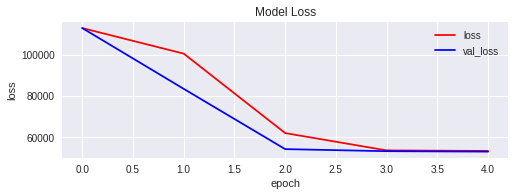

In [0]:
#plot the loss data
plt.subplot(211)
plt.plot(history.history['loss'],'r',label = 'loss')
plt.plot(history.history['val_loss'],'b', label = 'val_loss')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()



# fig = plt.figure()
# ax1 = fig.add_subplot(111)
# ax1.set_title('Location Scatter Plot')
# ax1.scatter(loc_prediction[:,0],loc_prediction[:,1],c = 'r',marker = 'o', label = 'predic')
# ax1.scatter(location_test[:,0],location_test[:,1],c = 'b',marker = 'x', label = 'test')
# plt.legend()
# plt.show()

('error distance is ', 298.4565772642957)
('max error distance is ', 547.0339340711733)
('min error distance is ', 25.242551642769815)


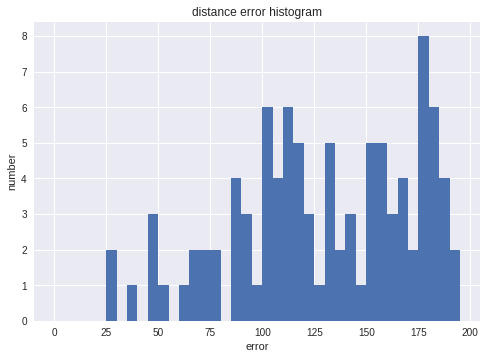

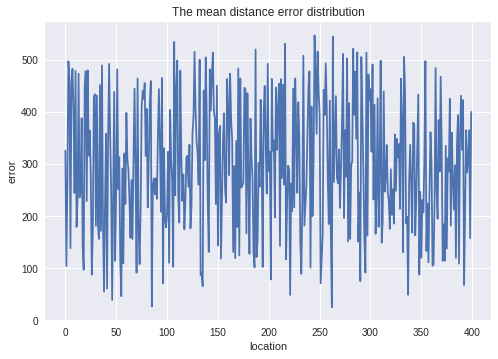

(400, 1)

In [0]:
#calculate the mean of error distance
err = loc_prediction - location_test
x = err[:,:1]
y = err[:,1:]

err_dis = np.sqrt(np.square(x)+np.square(y))
err_min = np.min(err_dis)
err_max = np.max(err_dis)
err_avg = np.mean(err_dis)
print("error distance is ", err_avg)
print("max error distance is ", err_max)
print("min error distance is ", err_min)
#set the value of x, y, z
x,y,z = location_test[:,:1],location_test[:,1:2],err_dis

#plot the 2D image of error
plt.figure(1)
#plt.subplot(2,1,2)
plt.hist(err_dis, bins =  range(0,200,5)) 
plt.xlabel("error")
plt.ylabel("number")
plt.title("distance error histogram") 

plt.figure(2)
#plt.subplot(2,1,1)
plt.plot(err_dis)
plt.title("The mean distance error distribution")
plt.xlabel("location")
plt.ylabel("error")
plt.show()
x.shape

Text(0.5,0.92,'The mean distance error of 3D Iamge')

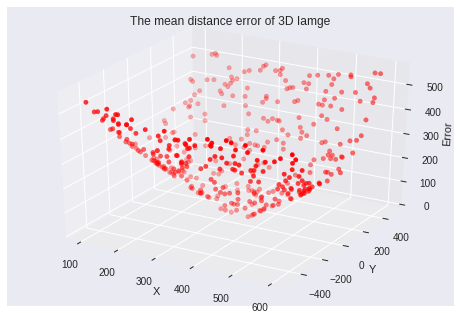

In [0]:
#plot 3D image
ax = plt.subplot(111,projection='3d')
ax.scatter(x,y,z,c='r')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Error")
plt.title("The mean distance error of 3D Iamge")

Text(0.5,1,"The mean distance error of 'heat map'")

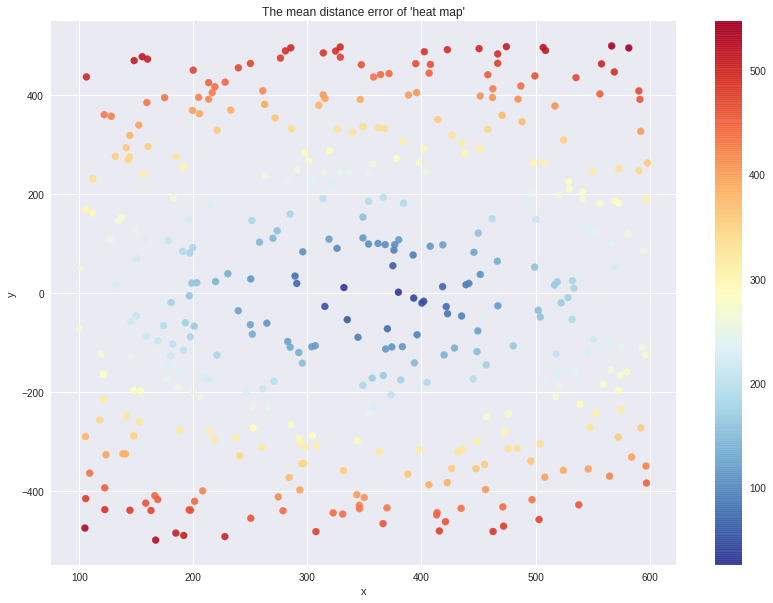

In [0]:
#draw the "heatmap" of error
fig = plt.figure(figsize=(14,10))
ax3 = fig.add_subplot(111)
cm = plt.cm.get_cmap('RdYlBu_r') #Accent  RdYlBu_r RdYlBu  Blues_r  Greens  YlOrBr_r

sc = ax3.scatter(x,y,c = z, marker = 'o', label = 'test',alpha=0.9, cmap=cm)
plt.colorbar(sc)
ax3.set_xlabel("x")
ax3.set_ylabel("y")
plt.title("The mean distance error of 'heat map'")

the mean of error 178.384831
the max of error 265.606897
the max of error 67.882757


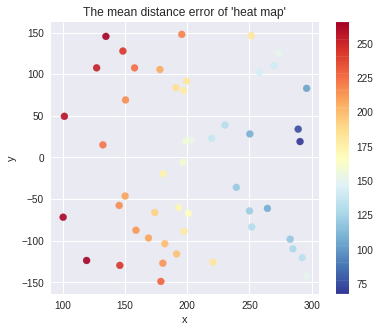

In [0]:
#plot small scale error map

err_map = np.hstack((location_test, err_dis))
err_map = pd.DataFrame(err_map, columns=['x', 'y', 'err'])
err_map_300 = err_map[err_map['x']<300]
err_map_300 = err_map_300[err_map_300['y']<150]
err_map_300 = err_map_300[err_map_300['y']>-150]
# np.array(err_map_300['x'])
print('the mean of error %f'% err_map_300['err'].mean())
print('the max of error %f'% err_map_300['err'].max())
print('the max of error %f'% err_map_300['err'].min())

fig = plt.figure(figsize=(6,5))
ax4 = fig.add_subplot(111)
cm = plt.cm.get_cmap('RdYlBu_r') #Accent  RdYlBu_r RdYlBu  Blues_r  Greens  YlOrBr_r
sc = ax4.scatter(np.array(err_map_300['x']),np.array(err_map_300['y']),c = np.array(err_map_300['err']), marker = 'o', label = 'test',alpha=0.9, cmap=cm)
plt.colorbar(sc)
ax4.set_xlabel("x")
ax4.set_ylabel("y")
plt.title("The mean distance error of 'heat map'")
plt.show()


In [0]:

#plot the 2D image of error
plt.figure(1)
#plt.subplot(2,1,2)
plt.hist(np.array(err_map_300['err']), bins =  range(0,45,1)) 
plt.xlabel("error")
plt.ylabel("number")
plt.title("distance error histogram") 